<a href="https://colab.research.google.com/github/forminju/DACON_anomaly_detection_/blob/main/0221_1_1___smartfactory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install pytorch-tabnet==3.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)

import os
import wget
from pathlib import Path
import random

from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
import os
import random
import time
import pickle
import psutil
import gc


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold

import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric

# setting some globl config

plt.style.use('ggplot')
orange_black = [
    '#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820'
]
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams["figure.facecolor"] = '#FFFACD'
plt.rcParams["axes.facecolor"] = '#FFFFE0'
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = orange_black[3]
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linestyle"] = '--'


import warnings
warnings.filterwarnings("ignore")

INFERENCE = True

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [7]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
seed_everything(42)

In [8]:
%cd /content/drive/MyDrive/스마트공장/0216

/content/drive/MyDrive/스마트공장/0216


# Data Load

In [9]:
train_df = pd.read_csv('group_1.csv')
test_df = pd.read_csv('test_group_1.csv')

In [10]:
train_x = train_df.drop(columns=['TIMESTAMP', 'Y_Class','Y_Quality'])
train_y = train_df['Y_Class']

test_x = test_df.drop(columns=['TIMESTAMP'])

In [11]:
train_x.drop(['LINE', 'PRODUCT_CODE'],axis=1, inplace=True)
test_x.drop(['LINE', 'PRODUCT_CODE'],axis=1, inplace=True)

# Imputation 기법 적용

In [12]:
train_x = train_x.dropna(axis=1)

In [13]:
train_x.iloc[:,1:]

,X_246,X_247,X_248,X_250,X_251,X_253,X_254,X_256,X_257,X_258,...,X_2856,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865
0,1.0,89.0,0.0,11.0,90.0,11.0,42.0,481.1,486.8,472.2,...,170.5,186.8,182.758621,175.7,182.0,174.727586,160.5,446.0,429.716981,413.0
1,1.0,95.0,0.0,11.0,98.0,11.0,42.0,481.4,488.3,471.2,...,173.2,195.0,184.365517,171.4,175.7,168.258621,158.3,446.0,429.301887,413.0
2,1.0,95.0,0.0,11.0,102.0,12.0,42.0,482.7,489.3,471.9,...,175.7,198.2,173.068965,163.7,184.1,173.479310,165.8,447.0,427.867925,407.0
3,1.0,95.0,0.0,11.0,105.0,11.0,42.0,485.0,491.7,473.4,...,173.0,192.0,180.396429,152.7,191.8,178.832143,168.6,446.0,428.403846,413.0
4,1.0,87.0,0.0,11.0,105.0,11.0,42.0,484.9,491.7,474.4,...,172.0,183.6,172.751724,146.9,182.4,170.379310,162.9,446.0,429.094340,406.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,1.0,93.0,107.0,11.0,0.0,12.0,51.0,485.8,492.9,476.1,...,199.7,222.6,193.278571,177.5,183.3,169.553571,154.2,456.0,438.132075,413.0
125,2.0,95.0,124.0,11.0,0.0,12.0,51.0,490.8,497.8,481.5,...,196.1,211.1,197.392857,173.1,187.6,182.142857,175.1,466.0,445.307692,425.0
126,1.0,89.0,136.0,12.0,0.0,12.0,51.0,494.4,502.1,484.9,...,203.2,205.1,194.860714,183.9,189.2,181.700000,172.7,466.0,444.615385,423.0
127,1.0,90.0,142.0,11.0,0.0,12.0,51.0,496.8,503.6,485.6,...,189.0,201.3,190.407143,181.1,192.6,185.207143,173.2,466.0,446.038461,427.0


In [14]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10)

imputer_output = imputer.fit_transform(train_x.iloc[:,1:])

In [15]:
train_x.iloc[:,1:] = pd.DataFrame(imputer_output, columns=train_x.iloc[:,1:].columns, index=list(train_x.iloc[:,1:].index.values));train_x

,PRODUCT_ID,X_246,X_247,X_248,X_250,X_251,X_253,X_254,X_256,X_257,...,X_2856,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865
0,TRAIN_028,1.0,89.0,0.0,11.0,90.0,11.0,42.0,481.1,486.8,...,170.5,186.8,182.758621,175.7,182.0,174.727586,160.5,446.0,429.716981,413.0
1,TRAIN_033,1.0,95.0,0.0,11.0,98.0,11.0,42.0,481.4,488.3,...,173.2,195.0,184.365517,171.4,175.7,168.258621,158.3,446.0,429.301887,413.0
2,TRAIN_039,1.0,95.0,0.0,11.0,102.0,12.0,42.0,482.7,489.3,...,175.7,198.2,173.068965,163.7,184.1,173.479310,165.8,447.0,427.867925,407.0
3,TRAIN_040,1.0,95.0,0.0,11.0,105.0,11.0,42.0,485.0,491.7,...,173.0,192.0,180.396429,152.7,191.8,178.832143,168.6,446.0,428.403846,413.0
4,TRAIN_041,1.0,87.0,0.0,11.0,105.0,11.0,42.0,484.9,491.7,...,172.0,183.6,172.751724,146.9,182.4,170.379310,162.9,446.0,429.094340,406.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,TRAIN_479,1.0,93.0,107.0,11.0,0.0,12.0,51.0,485.8,492.9,...,199.7,222.6,193.278571,177.5,183.3,169.553571,154.2,456.0,438.132075,413.0
125,TRAIN_501,2.0,95.0,124.0,11.0,0.0,12.0,51.0,490.8,497.8,...,196.1,211.1,197.392857,173.1,187.6,182.142857,175.1,466.0,445.307692,425.0
126,TRAIN_523,1.0,89.0,136.0,12.0,0.0,12.0,51.0,494.4,502.1,...,203.2,205.1,194.860714,183.9,189.2,181.700000,172.7,466.0,444.615385,423.0
127,TRAIN_531,1.0,90.0,142.0,11.0,0.0,12.0,51.0,496.8,503.6,...,189.0,201.3,190.407143,181.1,192.6,185.207143,173.2,466.0,446.038461,427.0


In [16]:
test_x = test_x[train_x.columns]

In [17]:
imputer_output_test = imputer.transform(test_x.iloc[:,1:])

In [18]:
test_x.iloc[:,1:] = pd.DataFrame(imputer_output_test, columns=test_x.iloc[:,1:].columns, index=list(test_x.iloc[:,1:].index.values));test_x

,PRODUCT_ID,X_246,X_247,X_248,X_250,X_251,X_253,X_254,X_256,X_257,...,X_2856,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865
0,TEST_003,1.0,93.0,0.0,11.0,37.0,11.0,42.0,475.5,479.3,...,159.4,201.3,179.739286,149.9,198.0,191.450000,183.8,467.0,444.192308,423.0
1,TEST_006,1.0,93.0,0.0,11.0,40.0,11.0,42.0,476.5,481.0,...,138.9,178.7,162.317241,120.6,201.5,194.351724,175.1,464.0,445.075472,423.0
2,TEST_010,1.0,90.0,0.0,11.0,46.0,11.0,42.0,477.6,482.7,...,166.9,198.6,174.050000,159.7,198.6,189.853571,174.4,466.0,444.115385,423.0
3,TEST_011,1.0,95.0,0.0,11.0,53.0,11.0,42.0,479.2,484.1,...,171.7,186.0,167.950000,146.8,197.1,187.360714,176.1,466.0,444.230769,422.0
4,TEST_038,2.0,88.0,0.0,11.0,134.0,11.0,42.0,504.0,510.4,...,165.1,185.2,158.975862,133.1,195.3,187.644828,180.1,462.0,447.962264,422.0
5,TEST_040,2.0,93.0,0.0,11.0,141.0,11.0,42.0,507.3,513.6,...,164.5,191.0,167.382759,143.7,204.2,197.510345,185.7,466.0,450.622641,432.0
6,TEST_071,2.0,89.0,0.0,11.0,6.0,11.0,42.0,454.6,460.7,...,164.4,198.0,182.293103,165.1,202.4,196.879310,187.1,465.0,444.792453,423.0
7,TEST_086,1.0,89.0,0.0,11.0,23.0,11.0,42.0,463.8,468.8,...,160.7,212.3,189.627586,161.8,202.4,196.593103,179.9,466.0,448.490566,433.0
8,TEST_088,17.0,90.0,0.0,11.0,23.0,11.0,42.0,464.8,470.0,...,220.5,308.8,274.425000,246.0,226.6,217.092857,206.3,466.0,442.480769,423.0
9,TEST_089,2.0,89.0,0.0,11.0,23.0,11.0,42.0,464.6,469.5,...,191.1,219.7,193.364286,175.9,201.8,197.789286,184.3,465.0,445.711539,426.0


In [19]:
train_x

,PRODUCT_ID,X_246,X_247,X_248,X_250,X_251,X_253,X_254,X_256,X_257,...,X_2856,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865
0,TRAIN_028,1.0,89.0,0.0,11.0,90.0,11.0,42.0,481.1,486.8,...,170.5,186.8,182.758621,175.7,182.0,174.727586,160.5,446.0,429.716981,413.0
1,TRAIN_033,1.0,95.0,0.0,11.0,98.0,11.0,42.0,481.4,488.3,...,173.2,195.0,184.365517,171.4,175.7,168.258621,158.3,446.0,429.301887,413.0
2,TRAIN_039,1.0,95.0,0.0,11.0,102.0,12.0,42.0,482.7,489.3,...,175.7,198.2,173.068965,163.7,184.1,173.479310,165.8,447.0,427.867925,407.0
3,TRAIN_040,1.0,95.0,0.0,11.0,105.0,11.0,42.0,485.0,491.7,...,173.0,192.0,180.396429,152.7,191.8,178.832143,168.6,446.0,428.403846,413.0
4,TRAIN_041,1.0,87.0,0.0,11.0,105.0,11.0,42.0,484.9,491.7,...,172.0,183.6,172.751724,146.9,182.4,170.379310,162.9,446.0,429.094340,406.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,TRAIN_479,1.0,93.0,107.0,11.0,0.0,12.0,51.0,485.8,492.9,...,199.7,222.6,193.278571,177.5,183.3,169.553571,154.2,456.0,438.132075,413.0
125,TRAIN_501,2.0,95.0,124.0,11.0,0.0,12.0,51.0,490.8,497.8,...,196.1,211.1,197.392857,173.1,187.6,182.142857,175.1,466.0,445.307692,425.0
126,TRAIN_523,1.0,89.0,136.0,12.0,0.0,12.0,51.0,494.4,502.1,...,203.2,205.1,194.860714,183.9,189.2,181.700000,172.7,466.0,444.615385,423.0
127,TRAIN_531,1.0,90.0,142.0,11.0,0.0,12.0,51.0,496.8,503.6,...,189.0,201.3,190.407143,181.1,192.6,185.207143,173.2,466.0,446.038461,427.0


# 랭크 가우스 정규화

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
scaler = StandardScaler()

In [22]:
#train data 변환
X_group_train = scaler.fit_transform(train_x.iloc[:,1:])

#test data 변환
X_group_test = scaler.transform(test_x.iloc[:,1:])

In [23]:
train_x.iloc[:,1:] = pd.DataFrame(X_group_train, columns=train_x.iloc[:,1:].columns, index=list(train_x.iloc[:,1:].index.values));train_x

,PRODUCT_ID,X_246,X_247,X_248,X_250,X_251,X_253,X_254,X_256,X_257,...,X_2856,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865
0,TRAIN_028,-0.383751,-0.716617,-0.816720,-0.744457,1.012325,-1.159937,-1.089239,-0.107828,-0.141720,...,-0.853081,-0.902251,-0.482382,0.021791,-0.057559,0.234620,-0.053298,-1.780047,-1.630148,-1.244903
1,TRAIN_033,-0.383751,1.467090,-0.816720,-0.744457,1.167789,-1.159937,-1.089239,-0.088328,-0.050826,...,-0.692671,-0.285314,-0.340790,-0.344503,-0.692268,-0.435401,-0.252061,-1.780047,-1.687185,-1.244903
2,TRAIN_039,-0.383751,1.467090,-0.816720,-0.744457,1.245521,0.862116,-1.089239,-0.003829,0.009771,...,-0.544143,-0.044559,-1.336192,-1.000427,0.154011,0.105330,0.425540,-1.652760,-1.884222,-2.048535
3,TRAIN_040,-0.383751,1.467090,-0.816720,-0.744457,1.303821,-1.159937,-1.089239,0.145669,0.155201,...,-0.704553,-0.511023,-0.690528,-1.937461,0.929767,0.659748,0.678511,-1.780047,-1.810582,-1.244903
4,TRAIN_041,-0.383751,-1.444519,-0.816720,-0.744457,1.303821,-1.159937,-1.089239,0.139169,0.155201,...,-0.763964,-1.143007,-1.364146,-2.431533,-0.017260,-0.215751,0.163535,-1.780047,-1.715703,-2.182474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,TRAIN_479,-0.383751,0.739187,0.999193,-0.744457,-0.736647,0.862116,0.918073,0.197668,0.227917,...,0.881728,1.791205,0.444589,0.175124,0.073413,-0.301277,-0.622482,-0.507175,-0.473855,-1.244903
125,TRAIN_501,0.626531,1.467090,1.287702,-0.744457,-0.736647,0.862116,0.918073,0.522663,0.524838,...,0.667847,0.925989,0.807122,-0.199689,0.506627,1.002654,1.265766,0.765696,0.512125,0.362361
126,TRAIN_523,-0.383751,-0.716617,1.491356,1.343260,-0.736647,0.862116,0.918073,0.756660,0.785401,...,1.089667,0.474571,0.584001,0.720307,0.667823,0.956786,1.048933,0.765696,0.416997,0.094484
127,TRAIN_531,-0.383751,-0.352666,1.593183,-0.744457,-0.736647,0.862116,0.918073,0.912658,0.876295,...,0.246027,0.188674,0.191572,0.481790,1.010365,1.320037,1.094107,0.765696,0.612538,0.630239


In [24]:
test_x.iloc[:,1:] = pd.DataFrame(X_group_test, columns=test_x.iloc[:,1:].columns, index=list(test_x.iloc[:,1:].index.values))

#TabNet 구현

In [25]:
train_x

,PRODUCT_ID,X_246,X_247,X_248,X_250,X_251,X_253,X_254,X_256,X_257,...,X_2856,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865
0,TRAIN_028,-0.383751,-0.716617,-0.816720,-0.744457,1.012325,-1.159937,-1.089239,-0.107828,-0.141720,...,-0.853081,-0.902251,-0.482382,0.021791,-0.057559,0.234620,-0.053298,-1.780047,-1.630148,-1.244903
1,TRAIN_033,-0.383751,1.467090,-0.816720,-0.744457,1.167789,-1.159937,-1.089239,-0.088328,-0.050826,...,-0.692671,-0.285314,-0.340790,-0.344503,-0.692268,-0.435401,-0.252061,-1.780047,-1.687185,-1.244903
2,TRAIN_039,-0.383751,1.467090,-0.816720,-0.744457,1.245521,0.862116,-1.089239,-0.003829,0.009771,...,-0.544143,-0.044559,-1.336192,-1.000427,0.154011,0.105330,0.425540,-1.652760,-1.884222,-2.048535
3,TRAIN_040,-0.383751,1.467090,-0.816720,-0.744457,1.303821,-1.159937,-1.089239,0.145669,0.155201,...,-0.704553,-0.511023,-0.690528,-1.937461,0.929767,0.659748,0.678511,-1.780047,-1.810582,-1.244903
4,TRAIN_041,-0.383751,-1.444519,-0.816720,-0.744457,1.303821,-1.159937,-1.089239,0.139169,0.155201,...,-0.763964,-1.143007,-1.364146,-2.431533,-0.017260,-0.215751,0.163535,-1.780047,-1.715703,-2.182474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,TRAIN_479,-0.383751,0.739187,0.999193,-0.744457,-0.736647,0.862116,0.918073,0.197668,0.227917,...,0.881728,1.791205,0.444589,0.175124,0.073413,-0.301277,-0.622482,-0.507175,-0.473855,-1.244903
125,TRAIN_501,0.626531,1.467090,1.287702,-0.744457,-0.736647,0.862116,0.918073,0.522663,0.524838,...,0.667847,0.925989,0.807122,-0.199689,0.506627,1.002654,1.265766,0.765696,0.512125,0.362361
126,TRAIN_523,-0.383751,-0.716617,1.491356,1.343260,-0.736647,0.862116,0.918073,0.756660,0.785401,...,1.089667,0.474571,0.584001,0.720307,0.667823,0.956786,1.048933,0.765696,0.416997,0.094484
127,TRAIN_531,-0.383751,-0.352666,1.593183,-0.744457,-0.736647,0.862116,0.918073,0.912658,0.876295,...,0.246027,0.188674,0.191572,0.481790,1.010365,1.320037,1.094107,0.765696,0.612538,0.630239


In [26]:
train_y

0      0
1      1
2      1
3      1
4      1
      ..
124    1
125    1
126    1
127    2
128    0
Name: Y_Class, Length: 129, dtype: int64

# valid 셋 구축

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [29]:
col_name = train_x.iloc[:,1:].columns

In [30]:
col_name

Index(['X_246', 'X_247', 'X_248', 'X_250', 'X_251', 'X_253', 'X_254', 'X_256',
       'X_257', 'X_258',
       ...
       'X_2856', 'X_2857', 'X_2858', 'X_2859', 'X_2860', 'X_2861', 'X_2862',
       'X_2863', 'X_2864', 'X_2865'],
      dtype='object', length=735)

In [32]:
nunique = train_x.iloc[:,1:].nunique()
types = train_x.iloc[:,1:].dtypes

categorical_columns = []
categorical_dims =  {0}

features = [ col for col in train_x.iloc[:,1:].columns] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [0]
# define your embeddi

In [33]:
# network parameters
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax', # "sparsemax"
                 "gamma" : 1.3 # coefficient for feature reusage in the masks
                }

clf = TabNetClassifier(**tabnet_params)

Device used : cuda


In [34]:
test_x['Y_Class']=0

In [35]:
X_train = train_x[features].values
y_train = train_y.values

X_valid = valid_x[features].values
y_valid = valid_y.values

X_test = test_x[features].values
y_test = test_x['Y_Class'].values

In [36]:
X_train

array([[-0.38375054,  1.83104078, -0.78277755, ...,  0.76569644,
         0.89243772,  1.29993214],
       [-0.38375054,  1.46708969,  0.30337563, ..., -0.50717522,
        -0.05599993, -0.03945481],
       [ 9.71906973, -0.35266579, -0.81671983, ...,  0.25654777,
        -0.2457074 , -0.03945481],
       ...,
       [-0.38375054,  0.01128531,  1.52529796, ...,  0.76569644,
         1.19317765,  1.29993214],
       [-0.38375054,  0.01128531, -0.81671983, ...,  0.76569644,
         0.87414005,  0.09448389],
       [-0.38375054,  0.7391875 ,  1.74592283, ...,  0.76569644,
         0.88206738,  1.29993214]])

In [37]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [38]:
save_history = []
for _ in range(3):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['logloss'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False
    )

epoch 0  | loss: 1.59019 | train_logloss: 1.14268 | valid_logloss: 1.07287 |  0:00:03s
epoch 1  | loss: 1.48109 | train_logloss: 1.12403 | valid_logloss: 1.09879 |  0:00:03s
epoch 2  | loss: 1.3856  | train_logloss: 1.12369 | valid_logloss: 1.13846 |  0:00:03s
epoch 3  | loss: 1.38396 | train_logloss: 1.09496 | valid_logloss: 1.10212 |  0:00:03s
epoch 4  | loss: 1.05722 | train_logloss: 1.10101 | valid_logloss: 1.07474 |  0:00:03s
epoch 5  | loss: 1.1237  | train_logloss: 1.10275 | valid_logloss: 1.07694 |  0:00:03s
epoch 6  | loss: 1.01427 | train_logloss: 1.10908 | valid_logloss: 1.09145 |  0:00:03s
epoch 7  | loss: 1.06919 | train_logloss: 1.11275 | valid_logloss: 1.08279 |  0:00:03s
epoch 8  | loss: 1.1674  | train_logloss: 1.11165 | valid_logloss: 1.08835 |  0:00:03s
epoch 9  | loss: 1.0403  | train_logloss: 1.09752 | valid_logloss: 1.09455 |  0:00:03s
epoch 10 | loss: 1.08222 | train_logloss: 1.08762 | valid_logloss: 1.09719 |  0:00:03s
epoch 11 | loss: 0.99791 | train_logloss: 1

In [39]:
preds = clf.predict(X_test)

In [40]:
test_x['Y_Class'] = preds

In [41]:
test_x.to_csv("0221_group1_target.csv",index=False)

# 상관계수 확인

In [ ]:
train_x.iloc[:,:1192]

,X_1,X_2,X_5,X_7,X_8,X_9,X_11,X_12,X_13,X_15,...,X_2856,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865
0,6.2,97.1,10.9,45.0,10.0,31.0,505.85,511.47,498.64,0.0,...,181.60,139.60,131.646667,115.40,209.00,197.286667,189.00,383.0,368.296296,353.0
1,6.2,97.1,10.9,45.0,10.0,31.0,505.85,511.47,498.64,0.0,...,177.10,145.50,128.748276,119.70,198.00,193.296552,185.60,383.0,367.735849,353.0
2,6.2,97.1,10.9,45.0,10.0,31.0,505.85,511.47,498.64,0.0,...,183.60,128.00,115.365517,104.00,193.40,179.820690,165.50,383.0,367.320755,353.0
3,6.1,97.8,11.0,45.0,10.0,31.0,508.00,514.05,500.41,0.0,...,179.50,126.20,112.082759,94.50,190.30,181.920690,165.80,384.0,369.188679,353.0
4,6.1,97.8,11.0,45.0,10.0,31.0,508.00,514.05,500.41,0.0,...,188.00,152.10,138.066667,109.70,208.60,196.393333,182.60,383.0,367.351852,352.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,2.0,95.0,10.0,50.0,10.0,52.0,468.90,473.90,459.20,0.0,...,157.48,144.52,126.687655,112.74,180.28,171.567977,161.68,383.7,368.137352,351.7
594,6.2,98.1,11.0,45.0,10.0,31.0,503.13,508.79,495.61,0.0,...,168.20,185.10,159.527586,144.20,198.30,180.810345,168.70,384.0,369.811321,353.0
595,6.2,98.1,11.0,45.0,10.0,31.0,503.13,508.79,495.61,0.0,...,153.40,187.60,178.248276,159.60,186.50,176.486207,156.60,383.0,367.018868,352.0
596,40.0,94.0,11.0,45.0,10.0,31.0,505.80,510.90,497.10,0.0,...,157.48,144.52,126.687655,112.74,180.28,171.567977,161.68,383.7,368.137352,351.7


In [ ]:
X_group_train = train_x.iloc[:,:1192]
X_group_test = test_x.iloc[:,:1192]
#test_x.iloc[:,2:1848]

In [ ]:
train_y

0      1
1      2
2      1
3      2
4      1
      ..
593    1
594    0
595    0
596    1
597    1
Name: Y_Class, Length: 598, dtype: int64

In [ ]:
X_group_train['Y_Class'] = train_y; X_group_train

,X_1,X_2,X_5,X_7,X_8,X_9,X_11,X_12,X_13,X_15,...,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865,Y_Class
0,6.2,97.1,10.9,45.0,10.0,31.0,505.85,511.47,498.64,0.0,...,139.60,131.646667,115.40,209.00,197.286667,189.00,383.0,368.296296,353.0,1
1,6.2,97.1,10.9,45.0,10.0,31.0,505.85,511.47,498.64,0.0,...,145.50,128.748276,119.70,198.00,193.296552,185.60,383.0,367.735849,353.0,2
2,6.2,97.1,10.9,45.0,10.0,31.0,505.85,511.47,498.64,0.0,...,128.00,115.365517,104.00,193.40,179.820690,165.50,383.0,367.320755,353.0,1
3,6.1,97.8,11.0,45.0,10.0,31.0,508.00,514.05,500.41,0.0,...,126.20,112.082759,94.50,190.30,181.920690,165.80,384.0,369.188679,353.0,2
4,6.1,97.8,11.0,45.0,10.0,31.0,508.00,514.05,500.41,0.0,...,152.10,138.066667,109.70,208.60,196.393333,182.60,383.0,367.351852,352.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,2.0,95.0,10.0,50.0,10.0,52.0,468.90,473.90,459.20,0.0,...,144.52,126.687655,112.74,180.28,171.567977,161.68,383.7,368.137352,351.7,1
594,6.2,98.1,11.0,45.0,10.0,31.0,503.13,508.79,495.61,0.0,...,185.10,159.527586,144.20,198.30,180.810345,168.70,384.0,369.811321,353.0,0
595,6.2,98.1,11.0,45.0,10.0,31.0,503.13,508.79,495.61,0.0,...,187.60,178.248276,159.60,186.50,176.486207,156.60,383.0,367.018868,352.0,0
596,40.0,94.0,11.0,45.0,10.0,31.0,505.80,510.90,497.10,0.0,...,144.52,126.687655,112.74,180.28,171.567977,161.68,383.7,368.137352,351.7,1


In [ ]:
corr = X_group_train.corr(method='pearson'); corr

,X_1,X_2,X_5,X_7,X_8,X_9,X_11,X_12,X_13,X_15,...,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865,Y_Class
X_1,1.000000,0.135780,0.266400,-0.208639,-0.072145,-0.249786,0.103334,0.087103,0.124656,-0.016772,...,0.233607,0.240670,0.232461,0.113626,0.084880,0.053025,0.232470,0.229080,0.227643,0.007763
X_2,0.135780,1.000000,0.646256,-0.662246,-0.231448,-0.744886,0.400351,0.373100,0.461753,-0.098541,...,0.231433,0.240978,0.231463,0.096990,0.059541,0.021353,0.244489,0.242080,0.241645,-0.031145
X_5,0.266400,0.646256,1.000000,-0.773013,-0.228041,-0.854020,0.440216,0.402883,0.513865,-0.054562,...,0.313738,0.327762,0.315031,0.144928,0.094030,0.039688,0.335978,0.331396,0.329007,-0.015746
X_7,-0.208639,-0.662246,-0.773013,1.000000,0.350413,0.905146,-0.541016,-0.510941,-0.606252,0.040435,...,-0.291740,-0.302814,-0.290991,-0.130635,-0.091452,-0.051099,-0.305019,-0.301020,-0.299526,0.012935
X_8,-0.072145,-0.231448,-0.228041,0.350413,1.000000,0.267021,-0.144755,-0.139910,-0.153016,-0.007001,...,-0.086056,-0.089336,-0.086030,-0.039319,-0.027676,-0.015434,-0.089975,-0.088776,-0.088284,0.045866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X_2862,0.053025,0.021353,0.039688,-0.051099,-0.015434,-0.057159,0.053901,0.053672,0.055939,-0.003693,...,-0.018205,-0.031739,-0.043233,0.794572,0.920824,1.000000,-0.099392,-0.105601,-0.100946,0.037185
X_2863,0.232470,0.244489,0.335978,-0.305019,-0.089975,-0.336970,0.185043,0.165758,0.210227,-0.021528,...,0.859870,0.906049,0.919909,0.041265,-0.025752,-0.099392,1.000000,0.998874,0.996067,0.105076
X_2864,0.229080,0.242080,0.331396,-0.301020,-0.088776,-0.332516,0.182028,0.162853,0.206974,-0.021241,...,0.857525,0.903687,0.917876,0.036476,-0.031610,-0.105601,0.998874,1.000000,0.998169,0.104990
X_2865,0.227643,0.241645,0.329007,-0.299526,-0.088284,-0.330763,0.181307,0.162241,0.206048,-0.021123,...,0.854231,0.900512,0.915098,0.036497,-0.028689,-0.100946,0.996067,0.998169,1.000000,0.104724


In [ ]:
y_corr = corr[1192:]; y_corr

,X_1,X_2,X_5,X_7,X_8,X_9,X_11,X_12,X_13,X_15,...,X_2857,X_2858,X_2859,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865,Y_Class
Y_Class,0.007763,-0.031145,-0.015746,0.012935,0.045866,0.017185,0.037473,0.036918,0.031621,-0.001818,...,0.029211,0.041038,0.052846,0.045215,0.066563,0.037185,0.105076,0.10499,0.104724,1.0


In [ ]:
corr_y = y_corr.T; corr_y

,Y_Class
X_1,0.007763
X_2,-0.031145
X_5,-0.015746
X_7,0.012935
X_8,0.045866
...,...
X_2862,0.037185
X_2863,0.105076
X_2864,0.104990
X_2865,0.104724


In [ ]:
corr_y = corr_y.abs(); corr_y.describe()

,Y_Class
count,1.188000e+03
mean,6.458264e-02
std,5.557941e-02
min,2.154482e-07
25%,1.925878e-02
50%,4.991687e-02
75%,1.116460e-01
max,1.000000e+00


In [ ]:
corr_y = corr_y[corr_y>0.111646].dropna(axis=0); corr_y.T

,X_73,X_90,X_120,X_121,X_284,X_941,X_942,X_943,X_948,X_949,...,X_1697,X_2845,X_2846,X_2847,X_2848,X_2849,X_2850,X_2855,X_2856,Y_Class
Y_Class,0.157265,0.146422,0.161799,0.156704,0.114221,0.114044,0.114043,0.113813,0.128702,0.151688,...,0.132584,0.113293,0.113461,0.11325,0.15627,0.172656,0.171738,0.116398,0.134133,1.0


In [ ]:
corr_y.T.columns[:296]

Index(['X_73', 'X_90', 'X_120', 'X_121', 'X_284', 'X_941', 'X_942', 'X_943',
       'X_948', 'X_949',
       ...
       'X_1696', 'X_1697', 'X_2845', 'X_2846', 'X_2847', 'X_2848', 'X_2849',
       'X_2850', 'X_2855', 'X_2856'],
      dtype='object', length=296)

In [ ]:
use_columns = corr_y.T.columns[:296]

In [ ]:
use_columns

Index(['X_73', 'X_90', 'X_120', 'X_121', 'X_284', 'X_941', 'X_942', 'X_943',
       'X_948', 'X_949',
       ...
       'X_1696', 'X_1697', 'X_2845', 'X_2846', 'X_2847', 'X_2848', 'X_2849',
       'X_2850', 'X_2855', 'X_2856'],
      dtype='object', length=296)

In [ ]:
train_x = train_x[use_columns] 
test_x = test_x[use_columns] 

In [ ]:
train_x

,X_73,X_90,X_120,X_121,X_284,X_941,X_942,X_943,X_948,X_949,...,X_1696,X_1697,X_2845,X_2846,X_2847,X_2848,X_2849,X_2850,X_2855,X_2856
0,10.060,35.8,34.47,34.21,1.0,75.40,75.254839,75.10,54.258065,50.0,...,35.10,35.00,47.20,47.094444,47.00,39.0,32.722222,26.0,191.800000,181.60
1,10.060,35.8,34.47,34.21,1.0,75.50,75.278125,75.00,53.218750,50.0,...,35.10,35.00,47.10,47.084906,47.00,34.0,30.849057,27.0,188.755172,177.10
2,10.060,35.8,34.47,34.21,1.0,75.50,75.170968,75.00,52.451613,50.0,...,35.60,35.00,47.20,47.088679,47.00,35.0,30.603774,27.0,187.310345,183.60
3,10.033,35.7,34.55,34.30,1.0,75.30,75.125000,74.90,57.531250,50.0,...,35.10,35.00,47.20,47.105660,46.90,38.0,32.698113,27.0,187.203448,179.50
4,10.033,35.7,34.55,34.30,1.0,75.50,75.258065,75.10,50.000000,50.0,...,34.70,34.50,47.20,47.107407,47.00,36.0,32.888889,28.0,194.546667,188.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,10.090,36.0,34.40,34.10,1.3,76.10,75.893891,75.67,103.818347,98.6,...,37.24,36.56,47.32,47.141642,47.02,37.7,32.523270,27.2,169.287253,157.48
594,10.025,35.7,34.58,34.33,1.0,75.30,75.164516,75.00,54.322581,50.0,...,37.70,36.20,47.50,47.254717,47.10,35.0,31.188679,25.0,183.893103,168.20
595,10.025,35.7,34.58,34.33,1.0,75.40,75.138710,74.90,52.870968,50.0,...,37.30,34.90,47.50,47.220755,47.10,37.0,31.207547,25.0,176.975862,153.40
596,10.220,35.0,33.90,33.70,1.3,76.10,75.893891,75.67,103.818347,98.6,...,37.24,36.56,47.32,47.141642,47.02,37.7,32.523270,27.2,169.287253,157.48


# 중요도 기반 변수 재생성

In [ ]:
importances = pd.DataFrame(model.feature_importances_,train_x.columns); importances

,0
X_73,1965
X_90,709
X_120,2011
X_121,1078
X_284,13
...,...
X_2848,0
X_2849,0
X_2850,0
X_2855,0


In [ ]:
importances.columns = ['importances'];importances

,importances
X_73,1965
X_90,709
X_120,2011
X_121,1078
X_284,13
...,...
X_2848,0
X_2849,0
X_2850,0
X_2855,0


In [ ]:
X_group_train.T

,0,1,2,3,4,5,6,7,8,9,...,588,589,590,591,592,593,594,595,596,597
X_73,0.534483,0.534483,0.534483,0.278293,0.278293,0.278293,0.278293,0.278293,0.278293,0.278293,...,0.819139,0.819139,0.819139,0.819139,1.767991,0.819139,0.202385,0.202385,2.052647,0.819139
X_90,-0.306783,-0.306783,-0.306783,-0.535531,-0.535531,-0.535531,-0.535531,-0.535531,-0.535531,-0.535531,...,0.150714,0.150714,0.150714,0.150714,-2.136768,0.150714,-0.535531,-0.535531,-2.136768,4.725678
X_120,-0.522280,-0.522280,-0.522280,-0.297040,-0.297040,-0.297040,-0.297040,-0.297040,-0.297040,-0.297040,...,-0.719365,-0.719365,-0.719365,-0.719365,-1.845565,-0.719365,-0.212575,-0.212575,-2.127115,-1.000915
X_121,-0.528290,-0.528290,-0.528290,-0.269765,-0.269765,-0.269765,-0.269765,-0.269765,-0.269765,-0.269765,...,-0.844265,-0.844265,-0.844265,-0.844265,-1.706015,-0.844265,-0.183590,-0.183590,-1.993265,-0.844265
X_284,-0.980711,-0.980711,-0.980711,-0.980711,-0.980711,-0.980711,-0.980711,-0.980711,-0.980711,-0.980711,...,0.253087,0.253087,0.253087,0.253087,0.253087,0.253087,-0.980711,-0.980711,0.253087,-0.158179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X_2848,0.682545,-2.933347,-2.210168,-0.040633,-1.486990,-2.210168,-2.210168,-0.763812,-2.210168,1.405723,...,-0.257587,-0.257587,-0.257587,-0.257587,-0.257587,-0.257587,-2.210168,-0.763812,-0.257587,-0.040633
X_2849,-0.229119,-1.482144,-1.646222,-0.245247,-0.117630,-1.482144,-1.789966,-0.358839,-1.740415,-0.253895,...,-0.362205,-0.362205,-0.362205,-0.362205,-0.362205,-0.362205,-1.254959,-1.242337,-0.362205,-0.285986
X_2850,-0.959295,-0.410182,-0.410182,-0.410182,0.138931,-0.410182,-0.959295,0.138931,-0.959295,0.138931,...,-0.300359,-0.300359,-0.300359,-0.300359,-0.300359,-0.300359,-1.508409,-1.508409,-0.300359,-0.355271
X_2855,1.146165,0.925232,0.820395,0.812638,1.345464,1.006049,0.559153,1.047583,0.447168,0.540529,...,-0.487365,-0.487365,-0.487365,-0.487365,-0.487365,-0.487365,0.572439,0.070522,-0.487365,-0.147820


In [ ]:
new_train_x  = X_group_train.T; new_train_x

,0,1,2,3,4,5,6,7,8,9,...,588,589,590,591,592,593,594,595,596,597
X_73,0.534483,0.534483,0.534483,0.278293,0.278293,0.278293,0.278293,0.278293,0.278293,0.278293,...,0.819139,0.819139,0.819139,0.819139,1.767991,0.819139,0.202385,0.202385,2.052647,0.819139
X_90,-0.306783,-0.306783,-0.306783,-0.535531,-0.535531,-0.535531,-0.535531,-0.535531,-0.535531,-0.535531,...,0.150714,0.150714,0.150714,0.150714,-2.136768,0.150714,-0.535531,-0.535531,-2.136768,4.725678
X_120,-0.522280,-0.522280,-0.522280,-0.297040,-0.297040,-0.297040,-0.297040,-0.297040,-0.297040,-0.297040,...,-0.719365,-0.719365,-0.719365,-0.719365,-1.845565,-0.719365,-0.212575,-0.212575,-2.127115,-1.000915
X_121,-0.528290,-0.528290,-0.528290,-0.269765,-0.269765,-0.269765,-0.269765,-0.269765,-0.269765,-0.269765,...,-0.844265,-0.844265,-0.844265,-0.844265,-1.706015,-0.844265,-0.183590,-0.183590,-1.993265,-0.844265
X_284,-0.980711,-0.980711,-0.980711,-0.980711,-0.980711,-0.980711,-0.980711,-0.980711,-0.980711,-0.980711,...,0.253087,0.253087,0.253087,0.253087,0.253087,0.253087,-0.980711,-0.980711,0.253087,-0.158179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X_2848,0.682545,-2.933347,-2.210168,-0.040633,-1.486990,-2.210168,-2.210168,-0.763812,-2.210168,1.405723,...,-0.257587,-0.257587,-0.257587,-0.257587,-0.257587,-0.257587,-2.210168,-0.763812,-0.257587,-0.040633
X_2849,-0.229119,-1.482144,-1.646222,-0.245247,-0.117630,-1.482144,-1.789966,-0.358839,-1.740415,-0.253895,...,-0.362205,-0.362205,-0.362205,-0.362205,-0.362205,-0.362205,-1.254959,-1.242337,-0.362205,-0.285986
X_2850,-0.959295,-0.410182,-0.410182,-0.410182,0.138931,-0.410182,-0.959295,0.138931,-0.959295,0.138931,...,-0.300359,-0.300359,-0.300359,-0.300359,-0.300359,-0.300359,-1.508409,-1.508409,-0.300359,-0.355271
X_2855,1.146165,0.925232,0.820395,0.812638,1.345464,1.006049,0.559153,1.047583,0.447168,0.540529,...,-0.487365,-0.487365,-0.487365,-0.487365,-0.487365,-0.487365,0.572439,0.070522,-0.487365,-0.147820


In [ ]:
importances.columns = ['im']; importances

,im
X_73,1965
X_90,709
X_120,2011
X_121,1078
X_284,13
...,...
X_2848,0
X_2849,0
X_2850,0
X_2855,0


In [ ]:
new_train_x = new_train_x.T.mul(importances['im'])

In [ ]:
new_train_x

,X_73,X_90,X_120,X_121,X_284,X_941,X_942,X_943,X_948,X_949,...,X_1696,X_1697,X_2845,X_2846,X_2847,X_2848,X_2849,X_2850,X_2855,X_2856
0,1050.259433,-217.508955,-1050.304945,-569.496733,-12.749246,-0.0,-26.333268,-15.284784,-134.615200,-65.726166,...,-37.014624,-64.322927,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
1,1050.259433,-217.508955,-1050.304945,-569.496733,-12.749246,-0.0,-26.286681,-15.401793,-138.053935,-65.726166,...,-37.014624,-64.322927,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0
2,1050.259433,-217.508955,-1050.304945,-569.496733,-12.749246,-0.0,-26.501062,-15.401793,-140.592129,-65.726166,...,-26.710672,-64.322927,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0
3,546.845783,-379.691443,-597.347327,-290.806843,-12.749246,-0.0,-26.593025,-15.518801,-123.785352,-65.726166,...,-37.014624,-64.322927,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0
4,546.845783,-379.691443,-597.347327,-290.806843,-12.749246,-0.0,-26.326815,-15.284784,-148.703676,-65.726166,...,-45.257787,-97.101594,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,1609.607933,106.856020,-1446.642860,-910.117711,3.290128,-0.0,-25.054770,-14.617838,29.362781,21.332381,...,7.086294,37.946515,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
594,397.686183,-379.691443,-427.488220,-197.910212,-12.749246,-0.0,-26.513969,-15.401793,-134.401738,-65.726166,...,16.565930,14.345874,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0
595,397.686183,-379.691443,-427.488220,-197.910212,-12.749246,-0.0,-26.565598,-15.518801,-139.204628,-65.726166,...,8.322768,-70.878660,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0
596,4033.451433,-1514.968859,-4277.627972,-2148.739448,3.290128,-0.0,-25.054770,-14.617838,29.362781,21.332381,...,7.086294,37.946515,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [ ]:
new_test_x = X_group_test*importances['im']; new_test_x

,X_73,X_90,X_120,X_121,X_284,X_941,X_942,X_943,X_948,X_949,...,X_1696,X_1697,X_2845,X_2846,X_2847,X_2848,X_2849,X_2850,X_2855,X_2856
0,2168.956433,106.856020,-2012.839883,-1219.773145,3.290128,-0.0,-25.054770,-14.617838,29.362781,21.332381,...,7.086294,37.946515,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,4033.451433,-1514.968859,-4277.627972,-2148.739448,3.290128,-0.0,-25.054770,-14.617838,29.362781,21.332381,...,7.086294,37.946515,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,4033.451433,-1514.968859,-3711.430950,-2148.739448,3.290128,-0.0,-25.054770,-14.617838,29.362781,21.332381,...,7.086294,37.946515,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,546.845783,-379.691443,-597.347327,-290.806843,-12.749246,0.0,91.509422,53.515999,-30.029616,-39.214509,...,6.261977,-44.655727,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0
4,546.845783,-379.691443,-597.347327,-290.806843,-12.749246,0.0,91.668342,53.515999,-35.961184,-40.110173,...,6.261977,-77.434394,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,-2865.180067,106.856020,3082.933319,1567.125763,3.290128,-0.0,-25.054770,-14.617838,29.362781,21.332381,...,7.086294,37.946515,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
306,-68.437567,106.856020,251.948207,18.848592,3.290128,-0.0,-25.054770,-14.617838,29.362781,21.332381,...,7.086294,37.946515,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
307,-2865.180067,106.856020,3082.933319,1567.125763,3.290128,-0.0,-25.054770,-14.617838,29.362781,21.332381,...,7.086294,37.946515,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
308,-2305.831567,106.856020,1950.539274,1257.470329,3.290128,-0.0,-25.054770,-14.617838,29.362781,21.332381,...,7.086294,37.946515,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [ ]:
lgbm_grid.fit(new_train_x, train_y)

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 200, 300, 400, 500, 600],
                         'num_leaves': [6, 8, 12, 16]},
             scoring='f1_macro')

In [ ]:
model = lgbm_grid.best_estimator_
pred_group_1 = model.predict(new_test_x)

# INFERENCE

In [ ]:
%cd /content/drive/MyDrive/스마트공장

/content/drive/MyDrive/스마트공장


In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/스마트공장/sample_submission (3).csv')

In [ ]:
test_predictions

array([0.56636245, 0.57440425, 0.7747038 , 0.64307668, 0.59987435,
       0.40017051, 0.79994291, 0.56821321, 0.9730362 , 0.79995239,
       0.40001854, 0.59790602, 0.59999114, 0.77734302, 0.97380726,
       0.95240128, 0.67119878, 0.90427022, 0.37589153, 0.77610913,
       0.7512383 , 0.77617695, 0.77446946, 0.77533486, 0.71650531,
       0.77030558, 0.48767569, 0.75817947, 0.95394434, 0.76121615,
       0.76975543, 0.57346165, 0.3893635 , 0.77396175, 0.57385644,
       0.97100222, 0.97531982, 0.4000041 , 0.12975962, 0.79993576,
       0.59986724, 0.79999477, 0.77794062, 0.35358632, 0.28661984,
       0.57542302, 0.77724603, 0.77007731, 0.97427931, 0.60237066,
       0.76580809, 0.77023471, 0.80000001, 0.97791453, 0.5713799 ,
       0.69722096, 0.77473205, 0.75588892, 0.7692482 , 0.56045762,
       0.62938311, 0.97309534, 0.97416703, 0.79999514, 0.82752188,
       0.78078942, 0.78060286, 0.72355425, 0.74020086, 0.76671548,
       0.7179243 , 0.79995677, 0.72258652, 0.76944749, 0.52964

In [ ]:
submit['Y_Class'] = pred_group_1

In [ ]:
submit.to_csv('0219preds_1.csv', index=False)

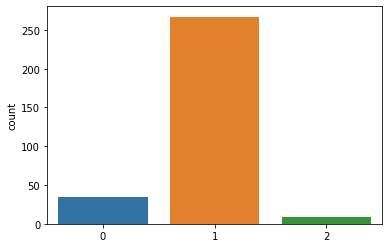

In [ ]:
sns.countplot(pred_group_1)

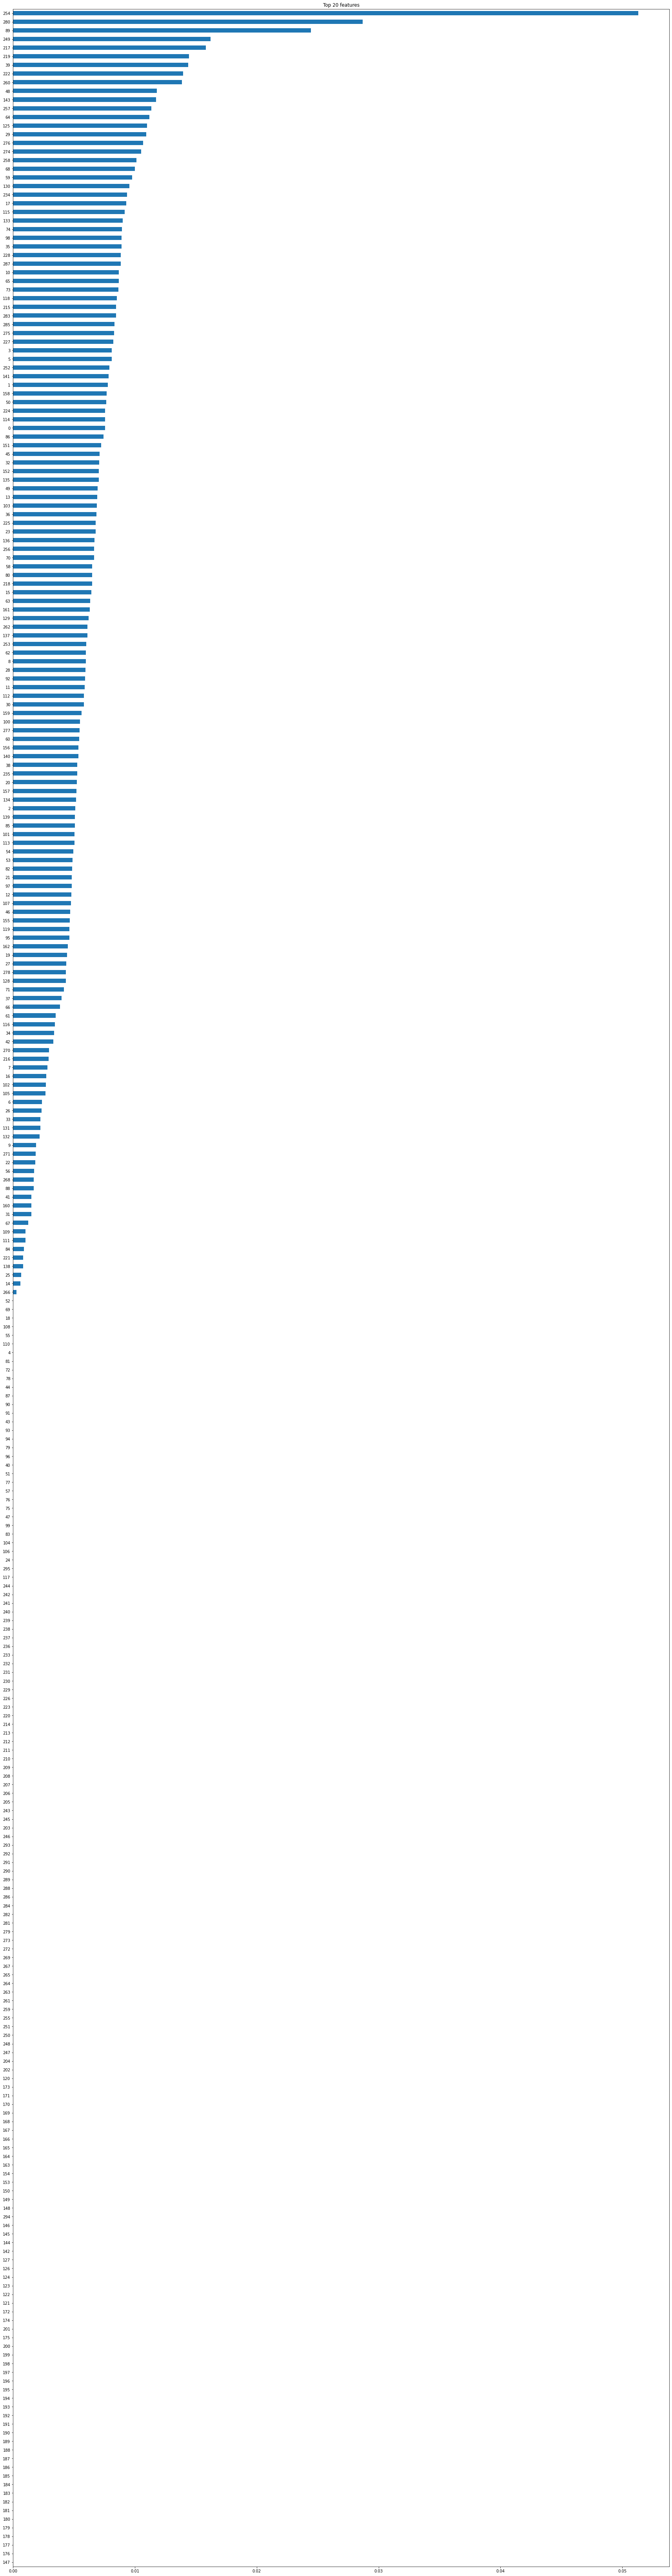

In [ ]:
model.feature_importances_

importances = pd.Series(model.feature_importances_, X_group_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n=20
plt.figure(figsize=(30,120))
plt.title(f'Top {n} features')
importances.sort_values().plot.barh()

In [ ]:
importances = pd.Series(model.feature_importances_, X_group_train.columns);importances

0      0.007539
1      0.007764
2      0.005114
3      0.008108
4      0.000000
         ...   
291    0.000000
292    0.000000
293    0.000000
294    0.000000
295    0.000000
Length: 296, dtype: float32

In [ ]:
pd.DataFrame(importances.sort_values(ascending=False))

,0
4,1320
2,1012
5,572
3,307
76,70
...,...
218,0
217,0
216,0
215,0


In [ ]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 13.0 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=b34b98bc8433433dd6441ae39b362607052b66e522af3c92c86ca6f82ef0b118
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatib